# Differences in PW at initialization time

In [1]:
# Import statements

from typing import List, Union

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import scienceplots  # noqa: F401
import xarray as xr
from dask.diagnostics import ProgressBar  # type: ignore
from joblib import delayed
from scipy.ndimage import gaussian_filter
from xskillscore.core.resampling import resample_iterations_idx

plt.style.use(["science", "nature"])
plt.rcParams["text.usetex"] = True


In [2]:
# Define useful functions
def get_wofs_all(init: int) -> xr.Dataset:
    """Read in WoFS output based on initialization time."""
    file_pattern = f"/mnt/drive2/new-wofs/{init:02d}Z/wofs_ALL*.nc"
    loaded = xr.open_mfdataset(
        file_pattern, combine="nested", concat_dim="time", chunks="auto"
    )

    if init < 6:
        start_time = f"2021-09-02 {init:02d}:00:00"
        end_time = f"2021-09-02 {init + 6:02d}:00:00"
    elif init == 17:
        start_time = f"2021-09-01 {init:02d}:00:00"
        end_time = f"2021-09-01 {init + 6:02d}:00:00"
    else:
        start_time = f"2021-09-01 {init:02d}:00:00"
        end_time = f"2021-09-02 {init - 24 + 6:02d}:00:00"


    loaded["time"] = xr.cftime_range(start_time, end_time, freq="5min")
    return loaded


def get_total_field(
    wofs_list: List[xr.Dataset],
    varname: str,
    start_time: str,
    end_time: str,
    init_dim: xr.DataArray,
) -> xr.DataArray:
    """
    Calculate the sum of a field (varname) for a given time slice across multiple datasets.

    Parameters:
    wofs_list (List[xr.Dataset]): List of xarray datasets.
    varname (str): Name of the variable from the Dataset to get.
    start_time (str): Start time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    end_time (str): End time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    init_dim (str): Name of the dimension to concatenate along.

    Returns:
    xr.DataArray: Summed-up variable concatenated along the specified dimension.
    """
    return xr.concat(
        [
            w[varname].sel(time=slice(start_time, end_time)).sum(dim="time")
            for w in wofs_list
        ],
        dim=init_dim,
    ).chunk({"init": -1})


def get_field(
    wofs_list: List[xr.Dataset],
    varname: str,
    start_time: str,
    end_time: str,
    init_dim: xr.DataArray,
) -> xr.DataArray:
    """
    Return a field (varname) for a given time slice across multiple datasets.

    Parameters:
    wofs_list (List[xr.Dataset]): List of xarray datasets.
    varname (str): Name of the variable from the Dataset to get.
    start_time (str): Start time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    end_time (str): End time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    init_dim (str): Name of the dimension to concatenate along.

    Returns:
    xr.DataArray: Summed-up variable concatenated along the specified dimension.
    """
    return xr.concat(
        [w[varname].sel(time=slice(start_time, end_time)) for w in wofs_list],
        dim=init_dim,
    ).chunk({"init": -1})

# Function to overwrite ne values
def overwrite_ne(da: xr.DataArray | xr.Dataset) -> xr.DataArray | xr.Dataset:
    da["ne"] = range(5)
    return da


def process_dim(da: xr.DataArray) -> xr.DataArray:
    """Helper function to process DataArray with or without time dimension"""
    ens_mean = da.mean(dim="run").stack(i=("lat", "lon"))
    sorted_mean = ens_mean.sortby(ens_mean)
    sorted_all = np.sort(da.values.flatten())[:: len(da.run)]
    sorted_mean.values = sorted_all
    return sorted_mean.unstack("i")


def pmm(da: xr.DataArray) -> xr.DataArray:
    """Compute the probability matched mean of a DataArray"""
    if "time" in da.dims:
        results = []
        for time_slice in da.time:
            time_da = da.sel(time=time_slice)
            results.append(process_dim(time_da))
        return xr.concat(results, dim="time")
    else:
        return process_dim(da)


@delayed
def bootstrap_iteration(da: xr.DataArray, sample_size: int) -> xr.DataArray:
    """Single iteration of bootstrapping"""
    # Sample without replacement
    sample1 = da.sel(run=np.random.choice(da.run, sample_size, replace=False))
    sample2 = da.sel(run=np.random.choice(da.run, sample_size, replace=False))

    # Compute PMM for each sample
    pmm1 = pmm(sample1)
    pmm2 = pmm(sample2)

    # Compute difference of PMMs
    diff = pmm1 - pmm2
    return diff


def bootstrap_pmm_difference(
    da: xr.DataArray, sample_size: int, iterations: int
) -> xr.DataArray:
    """Perform bootstrapping and compute differences of PMM"""
    tasks = [bootstrap_iteration(da, sample_size) for _ in range(iterations)]
    results = compute(*tasks)
    return xr.concat(results, dim="iteration")

def get_smoothed_ds(
    da: xr.DataArray, sigma: Union[float, int], axes: Union[str, List[str]] = None
):
    """
    Apply a Gaussian filter to specific dimensions of an xarray.DataArray and return
    a Dataset containing both the original and smoothed data.

    Parameters:
    - da (xr.DataArray): Input data array.
    - sigma (float or int): Standard deviation for the Gaussian kernel.
    - axes (str or List[str], optional): Dimensions to smooth over. Defaults to all dimensions.

    Returns:
    - xr.Dataset: A dataset containing the original and smoothed DataArrays.
    """
    # Type checking
    if not isinstance(da, xr.DataArray):
        raise TypeError("Input must be an xarray.DataArray.")
    if not isinstance(sigma, (float, int)):
        raise TypeError("Sigma must be a float or an integer.")
    if axes is not None and not isinstance(axes, (str, list)):
        raise TypeError("Axes must be a string, a list of strings, or None.")

    # Convert a single axis string to a list
    if isinstance(axes, str):
        axes = [axes]

    # If no axes specified, apply to all dimensions
    if axes is None:
        axes = list(da.dims)

    # Convert dimension names to axis indices
    try:
        axis_indices = [da.get_axis_num(dim) for dim in axes]
    except ValueError as e:
        raise ValueError(f"Invalid axis name in {axes}: {e}")

    # Construct full sigma array where only selected axes are smoothed
    full_sigma = [sigma if i in axis_indices else 0 for i in range(da.ndim)]

    # Apply the Gaussian filter
    smoothed_data = gaussian_filter(da.values, sigma=full_sigma)

    # Create a new DataArray with the same metadata
    smoothed_da = xr.DataArray(
        smoothed_data,
        dims=da.dims,
        coords=da.coords,
        attrs={
            **da.attrs,
            "description": f"Gaussian smoothed (sigma={sigma}) over {axes}",
        },
    )

    # Combine original and smoothed data into a Dataset
    ds = xr.Dataset({"original": da, "smoothed": smoothed_da})

    return ds


In [3]:
# Load in the 17Z initalizations
wofs = get_wofs_all(17)

# Define variables and parameters
lat = wofs.xlat.isel(time=0).squeeze().drop_vars("time")
lon = wofs.xlon.isel(time=0).squeeze().drop_vars("time")

# Set up Cartopy projection
proj = ccrs.LambertConformal(
    central_longitude=wofs.attrs["CEN_LON"],
    central_latitude=wofs.attrs["CEN_LAT"],
    standard_parallels=(30, 60),
)  # WoFS projection

# Set lists of wet and dry ensemble members
wet_ne = [4, 6, 7, 10]
dry_ne = [0, 5, 12, 16]

/tmp/ipykernel_3587989/1086533666.py:20: DeprecationWarning: cftime_range() is deprecated, please use xarray.date_range(..., use_cftime=True) instead.
  loaded["time"] = xr.cftime_range(start_time, end_time, freq="5min")


## Data Analysis

In [4]:
# Grab PW at initialization time
pw = get_smoothed_ds(wofs.pw.isel(time=0), sigma=3, axes=["lat", "lon"]).smoothed
pw_wet = xr.concat([pw.isel(ne=n) for n in wet_ne], dim="ne")
pw_dry = xr.concat([pw.isel(ne=n) for n in dry_ne], dim="ne")

In [5]:
# Chunk lat and lon of pw
pw_chunked = pw.squeeze().chunk({"lat": 25, "lon": 25})

# Resample and compute means
set1 = resample_iterations_idx(
    pw_chunked,
    1000,
    dim="ne",
    replace=False,
    dim_max=4,
).mean(dim="ne")

set2 = resample_iterations_idx(
    pw_chunked,
    1000,
    dim="ne",
    replace=False,
    dim_max=4,
).mean(dim="ne")

# Compute the difference and quantiles
with ProgressBar():
    result = (set1 - set2).quantile([0.025, 0.975], dim="iteration").compute()

# Get difference between wet and dry ensemble members
diff = (pw_wet.mean(dim="ne") - pw_dry.mean(dim="ne")).compute()

mask = (diff < result.sel(quantile=0.025).squeeze()) | (  # type: ignore
    diff > result.sel(quantile=0.975).squeeze()  # type: ignore
)

[########################################] | 100% Completed | 5.51 sms


/home/janoski/miniforge3/envs/wof/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1646: UserWarning: The following kwargs were not used by contour: 'rasterized'
  result = super().contourf(*args, **kwargs)


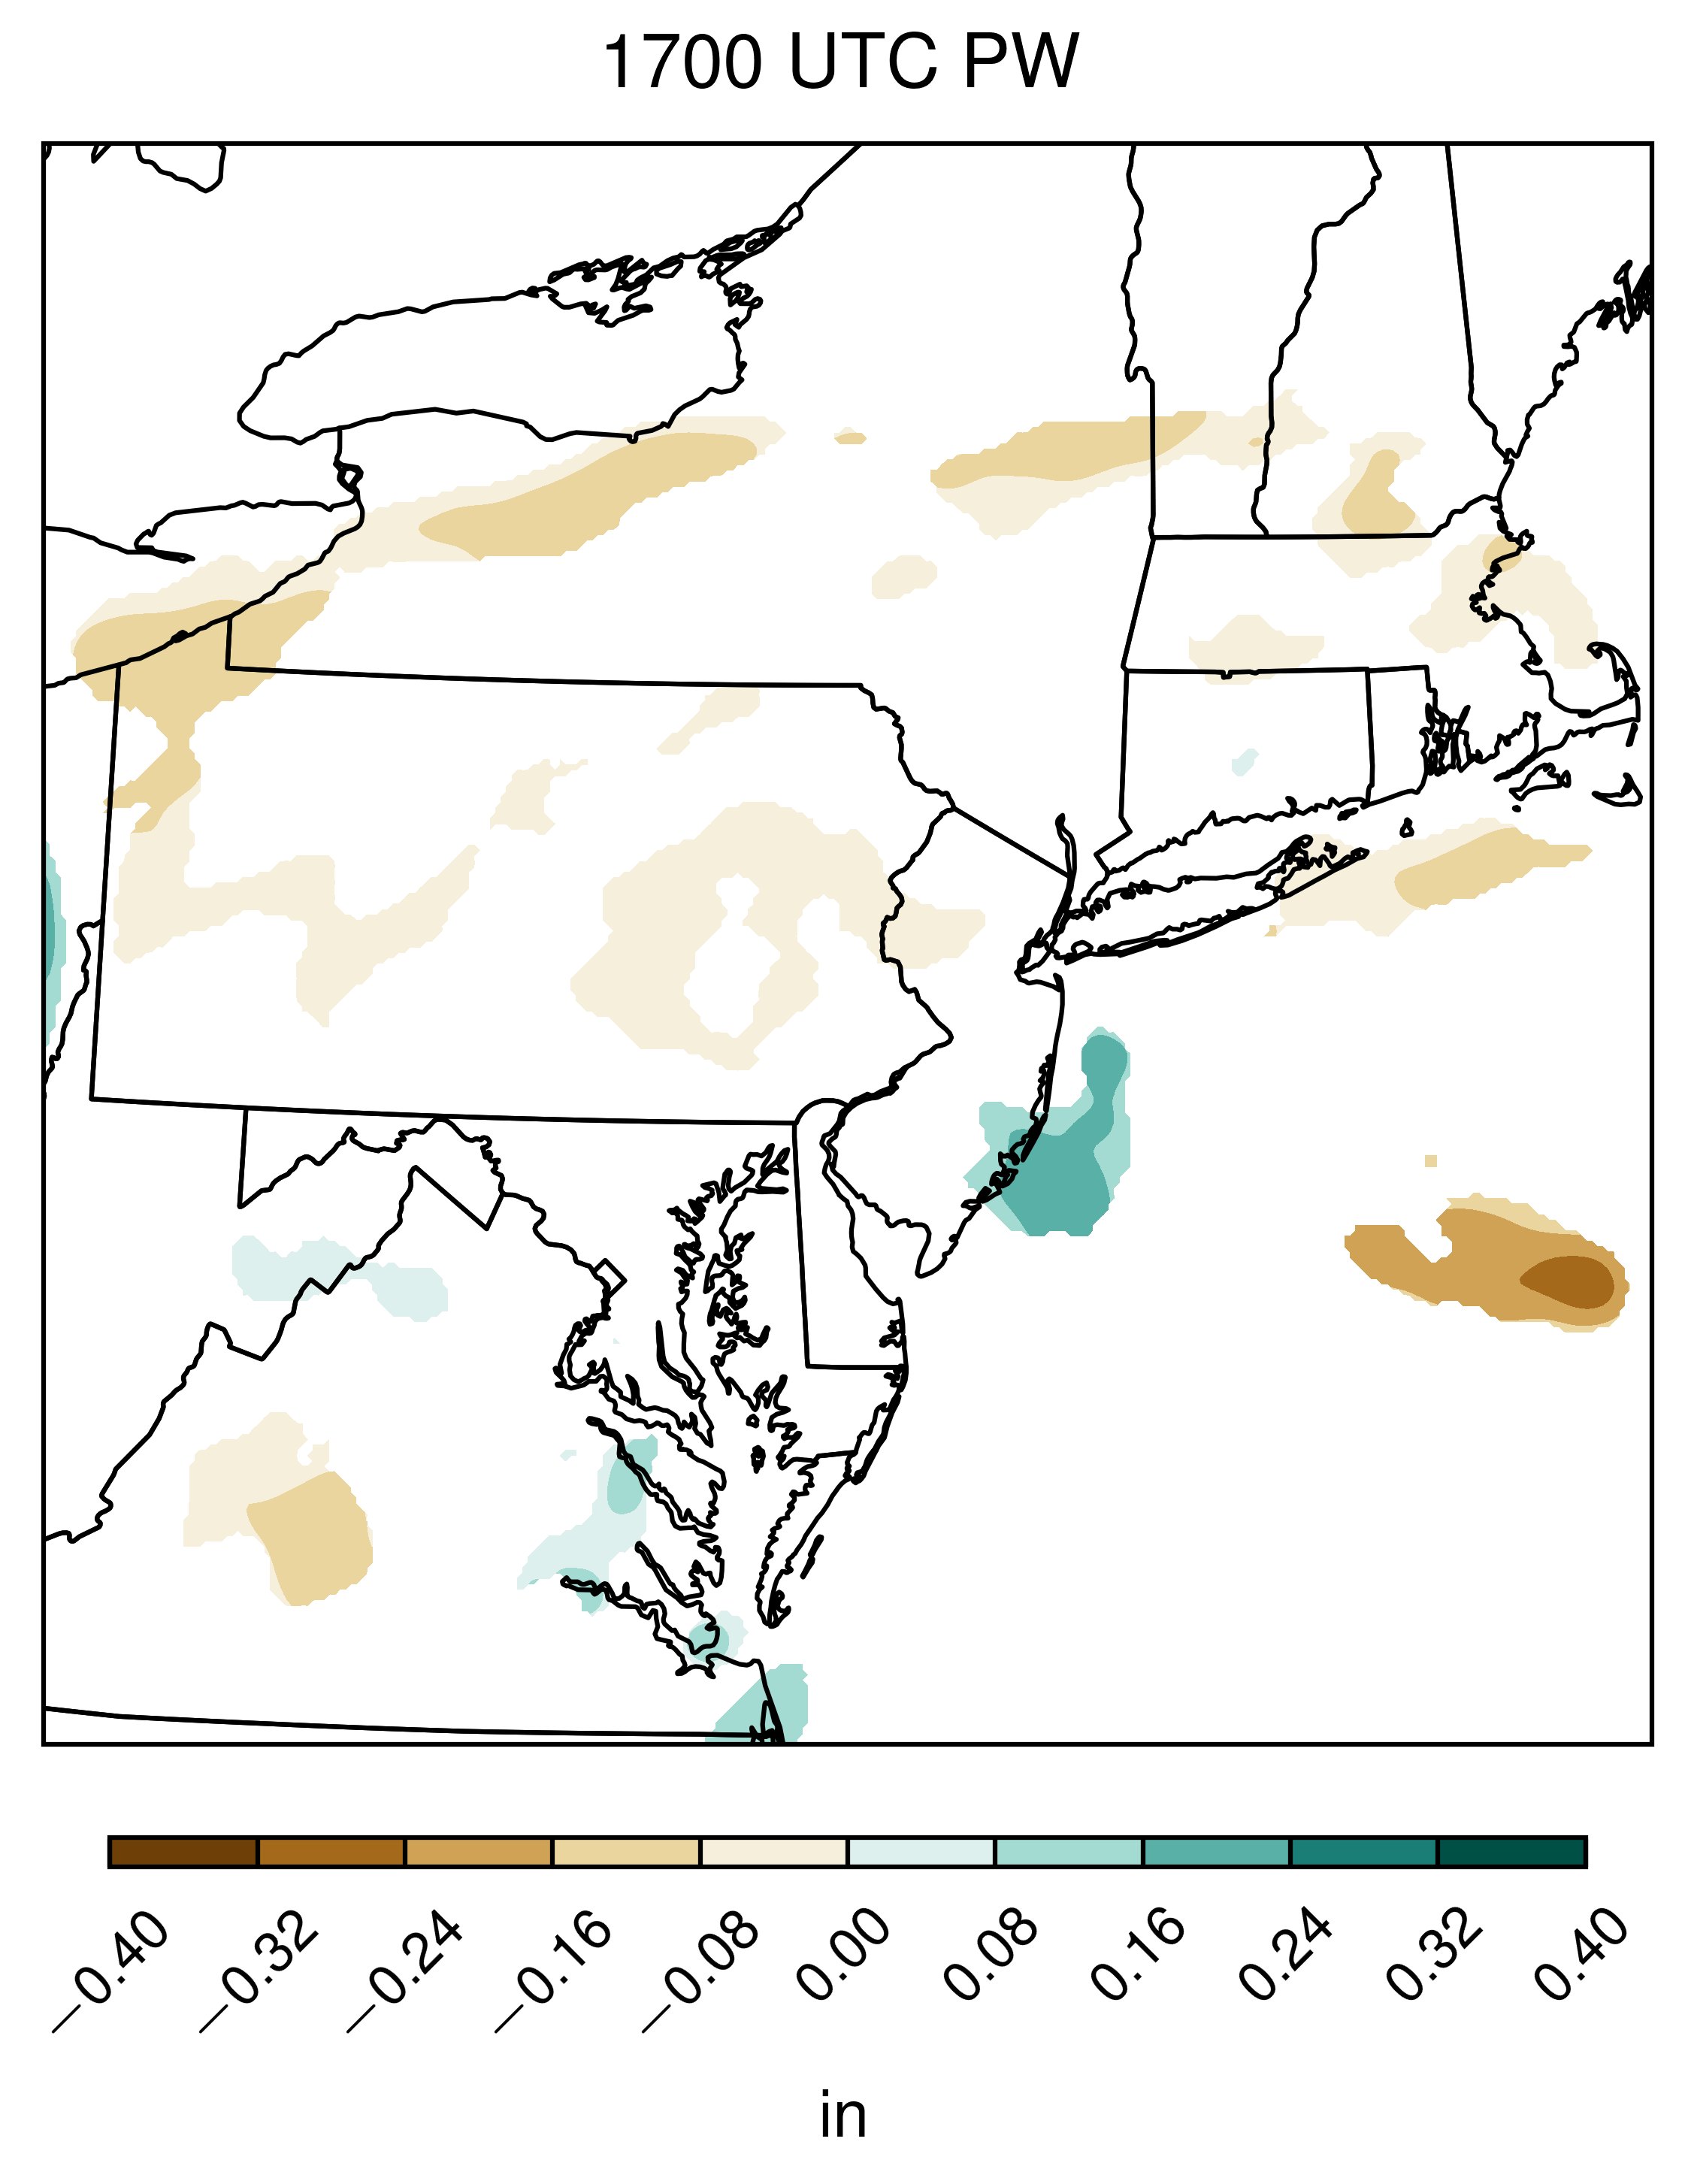

In [ ]:
levels = np.arange(-0.4, 0.41, 0.08)

# Make empty figure with subplots
fig, ax = plt.subplots(
    1,
    1,
    subplot_kw=dict(projection=proj),
    dpi=900,
    layout="constrained",
    figsize=(3.2, 3.2),
)

# Plot difference
c = ax.contourf(
    lon,
    lat,
    diff.where(mask),
    levels=levels,
    transform=ccrs.PlateCarree(),
    cmap="BrBG",
)

# Add states
c.axes.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="black")  # type: ignore

# Add colorbar to figure
cb = fig.colorbar(
    c,
    ax=ax,
    shrink=0.7,
    aspect=50,
    orientation="horizontal",
)
cb.ax.tick_params(labelsize=6, rotation=45)
cb.set_label("in", fontsize=7)
cb.set_ticks(levels)

ax.set_extent(  # type: ignore
    [
        -449900.09156094893,
        449900.51654555957,
        -447909.5438942791,
        448284.39736015256,
    ],
    crs=proj,
)

# Add title
plt.title("1700 UTC PW", fontsize=8)

# Save figure
plt.savefig("figures/Fig10_WoFS_PW_10UTC.pdf", bbox_inches="tight")
